# IBSR_23:Brain Tissue Segmentation Using Deep Learning
Author(s): **Mohammad Imran Hossain, Muhammad Zain Amin**
<br>University of Girona, Spain
<br>Erasmus Mundus Joint Master Degree in Medical Imaging and Applications

# Necessary Libraries

In [17]:
# Import all the necessary libraries
import os
import cv2
import glob
import random
import tqdm 
import scipy.misc
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import SimpleITK as sitk
from pathlib import Path
from scipy import ndimage
from tabulate import tabulate
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Input

from scipy.spatial.distance import directed_hausdorff

import segmentation_models as sm


# Import Dataset
- **Load the train and validation dataset from the dirctory**

In [3]:
# Define the path of the train and validation dataset directory
TRAIN_DATA_PATH = Path('/home/cad05/MISA/IBSR_18_BraTS_Deep_Learning/Dataset/Training_Set')
VALID_DATA_PATH = Path('/home/cad05/MISA/IBSR_18_BraTS_Deep_Learning/Dataset/Validation_Set')

In [4]:
# Define a function to load image dataset from a directory
def load_data(image_size, data_path):
    """
    Load image and label data from a specified directory path.

    Args:
    - image_size : Image dimensions (depth, height, width).
    - data_path  : Path of the directory containing image and label data.

    Returns:
    - images     :  List of images.
                           Shape: (num_images, depth, height, width, channels)
    - labels     :  List of labels.
                           Shape: (num_images, depth, height, width, channels)
    """
    # Count the number of images in the data path
    num_images = len(list(data_path.iterdir()))
    
    # Initialize arrays to store images and labels
    images = np.zeros((num_images, *image_size, 1))  
    labels = np.zeros((num_images, *image_size, 1))  

    # Progress bar initialization
    with tqdm(total=num_images, desc='Loading Progress') as pbar:
        idx = 0  
        # Loop through each image in the data path
        for image_path in data_path.iterdir():
            
            # Extract the image ID and define the image path
            image_id    = image_path.name  
            image_path  = data_path / image_id / f'{image_id}_bias.nii.gz'  
            
            # Read the image and convert into array
            image       = sitk.ReadImage(str(image_path))  
            image_array = sitk.GetArrayFromImage(image)
            image_array = image_array/np.max(image_array)
            image_array = image_array.reshape((*image_size, 1))  
            
            # Define the label path
            label_path  = data_path / image_id / f'{image_id}_seg.nii.gz' 
            
            # Read the label and convert into array
            label       = sitk.ReadImage(str(label_path))  
            label_array = sitk.GetArrayFromImage(label)  
            label_array = label_array.reshape((*image_size, 1))  

            # Insert loaded images and labels into arrays
            images[idx] = image_array
            labels[idx] = label_array
            idx += 1  
            
            pbar.update(1)  

    return (images, labels) 

# Define the image size
IMAGE_SIZE = (256, 128, 256)

# Read train and validation images and corresponding lables
(train_images, train_labels) = load_data(IMAGE_SIZE, TRAIN_DATA_PATH)
(valid_images, valid_labels) = load_data(IMAGE_SIZE, VALID_DATA_PATH)

print('Total Number of Train Images      : ', len(train_images))
print('Total Number of Validation Images : ', len(valid_images))

Loading Progress: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

Total Number of Train Images      :  10
Total Number of Validation Images :  5


- **Display train and validation images and corresponding labels**

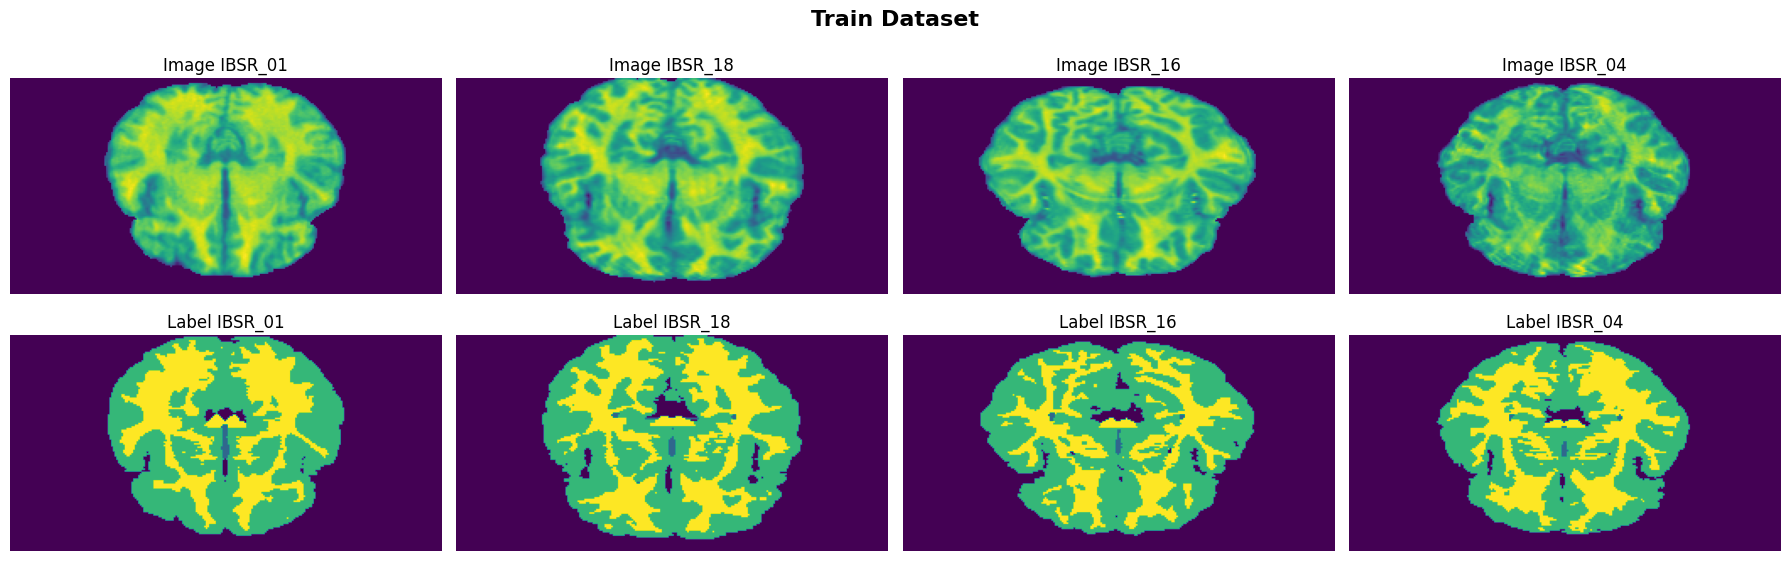

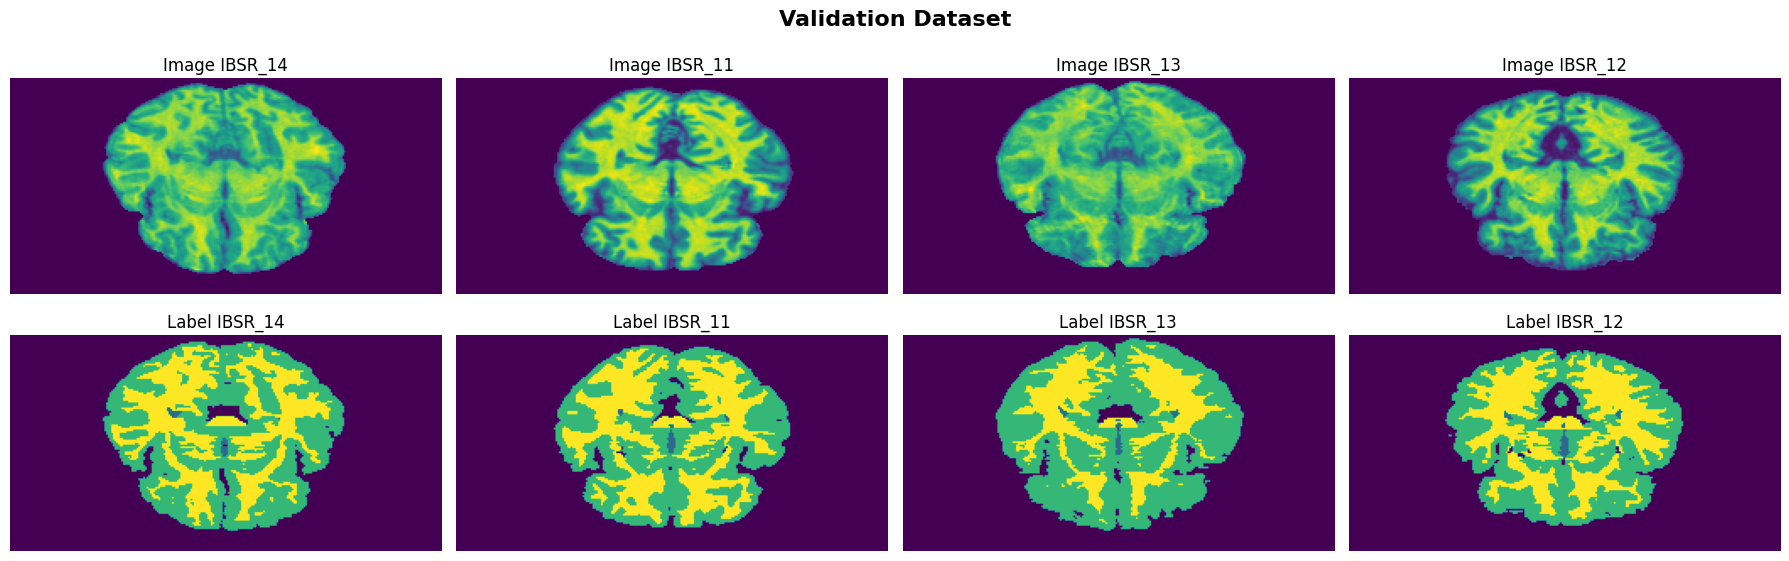

In [5]:
# Define a function to plot images and their corresponding labels
def plot_images_and_labels(images, labels, image_names, num_samples=4, dataset='Training Images'):
    """
    Plot images and their corresponding labels.

    Args:
    - images      : Array of images 
    - labels      : Array of labels 
    - image_names : List of image names or identifiers
    - num_samples : Number of samples to plot
    - dataset     : Type of Dataset
    """
    
    # Set the figure size
    plt.figure(figsize=(18, 6))
    
    # Define the slice number
    slice_num = 125

    # Select random indices for samples to plot
    random_indices = random.sample(range(len(images)), num_samples)

    # Iterate through the selected random indices
    for i, idx in enumerate(random_indices, 1):
        # Plot the image
        plt.subplot(2, num_samples, i)
        plt.imshow(images[idx, slice_num, :, :], cmap='viridis')  
        plt.title(f"Image {image_names[idx]}")  
        plt.axis('off')  

        # Plot the label
        plt.subplot(2, num_samples, i + num_samples)
        plt.imshow(labels[idx, slice_num, :, :], cmap='viridis')  
        plt.title(f"Label {image_names[idx]}")  
        plt.axis('off')  

    # Set a super title for the entire plot
    plt.suptitle(dataset, fontsize=16, fontweight='bold')
    plt.tight_layout()  
    plt.show()  


# Plot train images and corresponding labels
train_image_names = os.listdir(TRAIN_DATA_PATH)
plot_images_and_labels(train_images, train_labels, train_image_names, dataset='Train Dataset')

# Plot validation images and corresponding labels
valid_image_names = os.listdir(VALID_DATA_PATH)
plot_images_and_labels(valid_images, valid_labels, valid_image_names, dataset='Validation Dataset')

# Data Pre-processing
- **Split train dataset into training and training-validation for deep learning model**

In [6]:
# Split train dataset into training and validation (80:20)
training_images   = train_images[:8]
training_labels   = train_labels[:8]

validation_images = train_images[-2:]
validation_labels = train_labels[-2:]

print('Total Number of Training Images            :', len(training_images))
print('Total Number of Training-Validation Images :', len(validation_images))

Total Number of Training Images            : 8
Total Number of Training-Validation Images : 2


- **Extract patches from both the training and traininng-validation images and corresponding labels**

In [7]:
# Define required parameters for patch extraction
IMAGE_SIZE        = (256, 128, 256)  
PATCH_SIZE        = (32, 32)         
PATCH_STRIDE      = (32, 32)         
BATCH_SIZE        = 64              
N_CLASSES         = 4                
N_INPUT_CHANNELS  = 1                
CONTENT_THRESHOLD = 0.3    
dropout_rate      = 0.4

# Define a function to extract patches from images and labels
def extract_patches(images, 
                    labels, 
                    image_size  = IMAGE_SIZE, 
                    patch_size  = PATCH_SIZE, 
                    stride      = PATCH_STRIDE, 
                    threshold   = CONTENT_THRESHOLD, 
                    num_classes = N_CLASSES):
    
    """
    Extracts patches from input images and labels.

    Args:
    - images     : Input images.
    - labels     : Corresponding labels for the input images.
    - image_size : Dimensions of the input images (slice, height, width).
    - patch_size : Dimensions of the patches to be extracted (height, width).
    - stride     : Dimensions of the stride for patch extraction (vertical stride, horizontal stride).
    - threshold  : Threshold value to determine the usefulness of extracted patches.
    - num_classes: Number of classes in the dataset.

    Returns:
    - useful_image_patches: Extracted patches from input images.
    - useful_label_patches: Extracted patches from labels of the corresponding input images.
    """

    # Reshape images and labels for patch extraction
    images_reshaped = images.reshape([-1, image_size[1], image_size[2], 1])
    labels_reshaped = labels.reshape([-1, image_size[1], image_size[2], 1])

    # Extract patches from images
    image_patches = tf.image.extract_patches(
        images_reshaped,
        sizes   = [1, patch_size[0], patch_size[1], 1],
        strides = [1, stride[0], stride[1], 1],
        rates   = [1, 1, 1, 1],
        padding = 'SAME'
    ).numpy()

    # Extract patches from labels
    label_patches = tf.image.extract_patches(
        labels_reshaped,
        sizes   = [1, patch_size[0], patch_size[1], 1],
        strides = [1, stride[0], stride[1], 1],
        rates   = [1, 1, 1, 1],
        padding = 'SAME'
    ).numpy()

    # Reshape patches for further processing
    image_patches = image_patches.reshape([-1, *patch_size, 1])
    label_patches = label_patches.reshape([-1, *patch_size])

    # Masking to retain only foreground patches
    foreground_mask = label_patches != 0
    patch_product   = np.prod(patch_size)

    # Check for useful patches based on the threshold
    useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * patch_product

    # Filter patches based on usefulness
    useful_image_patches = image_patches[useful_patches]
    useful_label_patches = label_patches[useful_patches]

    # Convert label patches to one-hot encoded format
    useful_label_patches = tf.keras.utils.to_categorical(useful_label_patches, num_classes=num_classes, dtype='float32')

    return useful_image_patches, useful_label_patches

# Extract patches from training and validation images along with their corresponding labels
(training_image_patches, training_label_patches)     = extract_patches(training_images, training_labels)
(validation_image_patches, validation_label_patches) = extract_patches(validation_images, validation_labels)

print('Total Number of Patches from Training Images   : ', len(training_image_patches))
print('Total Number of Patches from Validation Images : ', len(validation_image_patches))

2024-01-12 12:43:15.857309: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Total Number of Patches from Training Images   :  9893
Total Number of Patches from Validation Images :  2895


- **Display some random patches for the vizualization**

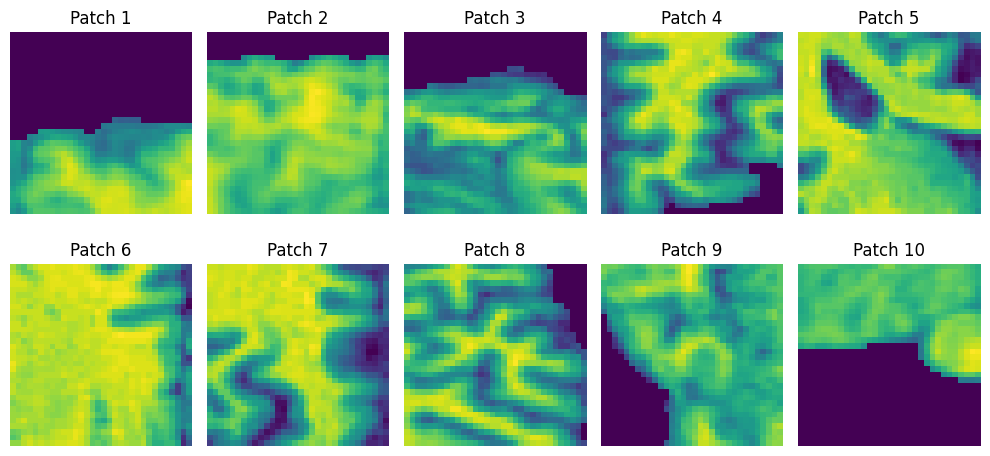

In [8]:
# Define the number of patches to plot
num_patches = 10

# Randomly select patches to plot
random_indices = np.random.choice(len(training_image_patches), num_patches, replace=False)

# Create a figure to plot the patches
plt.figure(figsize=(10, 5))

# Loop through each patch to plot
for i in range(num_patches):
    plt.subplot(2, 5, i + 1)  
    patch_index   = random_indices[i]  
    patch_to_plot = training_image_patches[patch_index]  
    plt.imshow(patch_to_plot, cmap='viridis')  
    plt.axis('off')  
    plt.title(f'Patch {i+1}')  

plt.tight_layout()  
plt.show()  

# Data Augmentation
- **Augment the training and training-validation dataset to handle data imbalance**

In [9]:
# Degree of Augmentation
DEGREE = 0.2

# Create the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range     = 40,            
    width_shift_range  = DEGREE,    
    height_shift_range = DEGREE,                
    shear_range        = DEGREE,          
    zoom_range         = DEGREE,            
    horizontal_flip    = True,        
    vertical_flip      = True,           
    fill_mode          ='nearest'  # fill_mode options: 'constant', 'nearest', 'reflect', 'wrap'
   
)

# Generate augmented training data and labels 
train_generator = datagen.flow(
    training_image_patches,
    batch_size=int(training_image_patches.shape[0] / BATCH_SIZE),  
    seed=1  
)

train_label_generator = datagen.flow(
    training_label_patches,
    batch_size=int(training_label_patches.shape[0] / BATCH_SIZE),  
    seed=1  
)

# Generate augmented training-validation data and labels 
validation_generator = datagen.flow(
    validation_image_patches,
    batch_size=int(validation_image_patches.shape[0] / BATCH_SIZE),  
    seed=1 
)

validation_label_generator = datagen.flow(
    validation_label_patches,
    batch_size=int(validation_label_patches.shape[0] / BATCH_SIZE),  
    seed=1  
)

In [10]:
# Retrieve batches of augmented data from the generators
X_train = train_generator.next()  
Y_train = train_label_generator.next()  

# Concatenate original and augmented data for the training set
total_train_images = np.concatenate((training_image_patches, X_train))
total_train_labels = np.concatenate((training_label_patches, Y_train))

# Retrieve batches of augmented data for the validation set
X_validation = validation_generator.next()  
Y_validation = validation_label_generator.next()  

# Concatenate original and augmented data for the validation set
total_validation_images = np.concatenate((validation_image_patches, X_validation))
total_validation_labels = np.concatenate((validation_label_patches, Y_validation))

# Display shapes of the datasets
print('---------Training Dataset----------')
print('Shape of Image Patches:', total_train_images.shape)
print('Shape of Label Patches:', total_train_labels.shape)

print('\n---------Validation Dataset----------')
print('Shape of Image Patches:', total_validation_images.shape)
print('Shape of Label Patches:', total_validation_labels.shape)


---------Training Dataset----------
Shape of Image Patches: (10047, 32, 32, 1)
Shape of Label Patches: (10047, 32, 32, 4)

---------Validation Dataset----------
Shape of Image Patches: (2940, 32, 32, 1)
Shape of Label Patches: (2940, 32, 32, 4)


# U-Net Model

In [11]:
# Define U-Net model architecture
def get_Unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    
    """
    Creates a U-Net model for image segmentation.

    Args:
    - img_size        : Size of the input image (height, width).
    - n_classes       : Number of classes for segmentation.
    - n_input_channels: Number of input channels.
    - scale           : Integer, scaling factor.

    Returns:
    - model           : Keras Model instance representing the U-Net architecture.
    """
    
    # Encoding Path of the UNet (32-64-128-256-512)
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    conv1   = Conv2D(32*scale, (3, 3), padding="same", activation='relu')(inputs)
    drop1   = Dropout(rate=dropout_rate)(conv1, training=True)
    max1    = MaxPooling2D((2, 2))(drop1)

    conv2   = Conv2D(64*scale, (3, 3), padding="same", activation='relu')(max1)
    drop2   = Dropout(rate=dropout_rate)(conv2, training=True)
    max2    = MaxPooling2D((2, 2))(drop2)

    conv3   = Conv2D(128*scale, (3, 3), padding="same", activation='relu')(max2)
    drop3   = Dropout(rate=dropout_rate)(conv3, training=True)
    max3    = MaxPooling2D((2, 2))(drop3)

    conv4   = Conv2D(256*scale, (3, 3), padding="same", activation='relu')(max3)
    drop4   = Dropout(rate=dropout_rate)(conv4, training=True)
    max4    = MaxPooling2D((2, 2))(drop4)

    lat     = Conv2D(512*scale, (3, 3), padding="same", activation='relu')(max4)
    drop5   = Dropout(rate=dropout_rate)(lat, training=True)

    # Decoding Path of the UNet
    up1     = UpSampling2D((2, 2))(drop5)
    concat1 = concatenate([conv4, up1], axis=-1)
    conv5   = Conv2D(256*scale, (3, 3), padding="same", activation='relu')(concat1)
    drop6   = Dropout(rate=dropout_rate)(conv5, training=True)
    
    up2     = UpSampling2D((2, 2))(drop6)
    concat2 = concatenate([conv3, up2], axis=-1)
    conv6   = Conv2D(128*scale, (3, 3), padding="same", activation='relu')(concat2)
    drop7   = Dropout(rate=dropout_rate)(conv6, training=True)
    
    up3     = UpSampling2D((2, 2))(drop7)
    concat3 = concatenate([conv2, up3], axis=-1)
    conv7   = Conv2D(64*scale, (3, 3), padding="same", activation='relu')(concat3)
    drop8   = Dropout(rate=dropout_rate)(conv7, training=True)

    up4     = UpSampling2D((2, 2))(drop8)
    concat4 = concatenate([conv1, up4], axis=-1)
    conv8   = Conv2D(32*scale, (3, 3), padding="same", activation='relu')(concat4)
    drop9   = Dropout(rate=dropout_rate)(conv8, training=True)
    
    outputs = Conv2D(n_classes, (1, 1), activation="softmax")(drop9)

    model = Model(inputs, outputs)

    return model


# Create an instance of the model
Unet_model = get_Unet()

# Display model summary
Unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           320       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 32, 32, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)           0         ['dropout[0][0]']             
 D)                                                                                           

# Train Model
- **Train the U-Net Model**

In [12]:
# Define training parameters
N_EPOCHS      = 200
BATCH_SIZE    = 64
PATIENCE      = 20
LEARNING_RATE = 0.001
MODEL_FNAME_PATTERN = 'unet.keras'
OPTIMIZER     = 'Adam'
dropout_rate  = 0.40
OPTIMIZER     = Adam(LEARNING_RATE)

# Define the loss 
dice_loss  = sm.losses.DiceLoss(class_weights=np.array([0.25,0.25,0.25,0.25]))
focal_loss = sm.losses.CategoricalCELoss()
LOSS       = dice_loss + (1*focal_loss)

# Define the performance metrics
metrics  = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Create the callback list with earlystopping and model checkpoint
callback_list = [
    tf.keras.callbacks.EarlyStopping(patience=PATIENCE), 
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True)]

# Compile the Unet model
Unet_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=metrics)

# Train the Unet model
history = Unet_model.fit(
    x               = total_train_images, 
    y               = total_train_labels,
    validation_data = (total_validation_images, total_validation_labels),
    batch_size      = BATCH_SIZE,
    epochs          = N_EPOCHS,
    callbacks       = callback_list,
    verbose         = 1)

Epoch 1/200


157/157 [==============================] - 30s 157ms/step - loss: 1.0130 - iou_score: 0.4565 - f1-score: 0.5474 - val_loss: 0.9614 - val_iou_score: 0.5443 - val_f1-score: 0.6353
Epoch 2/200
157/157 [==============================] - 22s 138ms/step - loss: 0.9107 - iou_score: 0.6915 - f1-score: 0.8066 - val_loss: 0.9294 - val_iou_score: 0.6178 - val_f1-score: 0.7106
Epoch 3/200
157/157 [==============================] - 21s 136ms/step - loss: 0.8774 - iou_score: 0.7586 - f1-score: 0.8585 - val_loss: 0.9274 - val_iou_score: 0.6279 - val_f1-score: 0.7203
Epoch 4/200
157/157 [==============================] - 22s 141ms/step - loss: 0.8604 - iou_score: 0.7885 - f1-score: 0.8792 - val_loss: 0.9025 - val_iou_score: 0.6848 - val_f1-score: 0.7684
Epoch 5/200
157/157 [==============================] - 22s 137ms/step - loss: 0.8506 - iou_score: 0.8059 - f1-score: 0.8905 - val_loss: 0.9071 - val_iou_score: 0.6671 - val_f1-score: 0.7514
Epoch 6/200
157/157 [==============================] - 21s 136

In [13]:
# Creating an instance of the U-Net model with specific configurations
Unet_model = get_Unet(img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
                                n_classes=N_CLASSES,
                                n_input_channels=N_INPUT_CHANNELS)

# Compiling the model with an optimizer and loss function for training
Unet_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=metrics)

# Loading pre-trained weights into the model from a saved file
Unet_model.load_weights('unet.keras')

- **Plot the Training and Validation Loss, IOU Score, F1 Score**

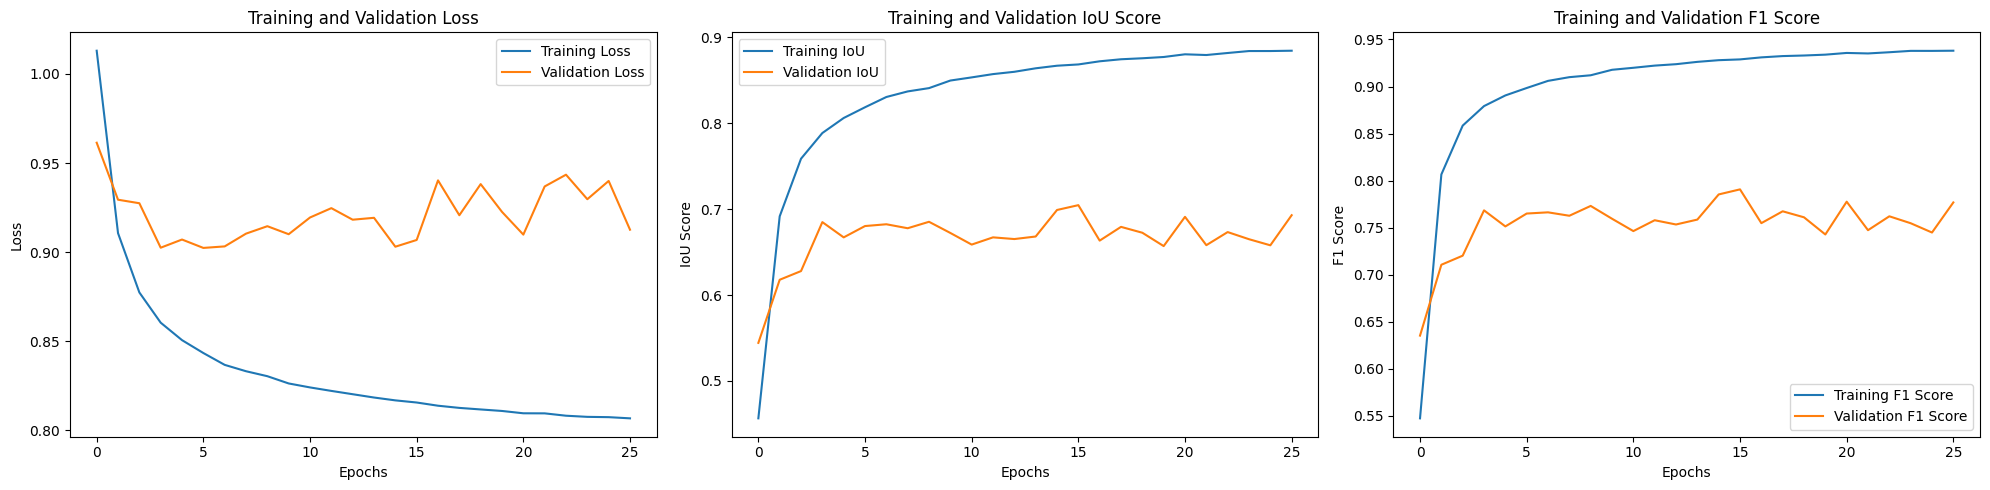

In [14]:
# Accessing metrics from the history object
training_loss   = history.history['loss']
validation_loss = history.history['val_loss']
training_iou    = history.history['iou_score']
validation_iou  = history.history['val_iou_score']
training_f1     = history.history['f1-score']
validation_f1   = history.history['val_f1-score']

# Creating subplots in a 1x3 grid
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plotting Loss
axs[0].plot(training_loss, label='Training Loss')
axs[0].plot(validation_loss, label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting IOU Score
axs[1].plot(training_iou, label='Training IoU')
axs[1].plot(validation_iou, label='Validation IoU')
axs[1].set_title('Training and Validation IoU Score')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('IoU Score')
axs[1].legend()

# Plotting F1 Score
axs[2].plot(training_f1, label='Training F1 Score')
axs[2].plot(validation_f1, label='Validation F1 Score')
axs[2].set_title('Training and Validation F1 Score')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('F1 Score')
axs[2].legend()

plt.tight_layout()
plt.show()

# Test Prediction
- **Prepare the validation that for making the prediction using the trained models**

In [15]:
# Define a function to prepare validation data for prediction using the trained model
def prepare_valid_data(valid_images, valid_labels):
    """
    Prepare validation data for prediction by reshaping images and labels.

    Args:
    - valid_images : Validation images data.
    - valid_labels : Validation labels data.

    Returns:
    - valid_images_reshaped: Reshaped validation images.
    - valid_labels_modified: Modified validation labels.
    """
    
    # Reshape the valid images and labels to match the required input shape for the model
    valid_images_reshaped = valid_images.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
    valid_labels_reshaped = valid_labels.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
    
    # Modify the validation labels to categorical format suitable for model prediction
    valid_labels_modified = tf.keras.utils.to_categorical(valid_labels_reshaped, num_classes=4, dtype='float32')
    
    return valid_images_reshaped, valid_labels_modified


- **Predict the validation dataset using trained UNet Model**

In [15]:
# Define lists to store processed validation labels and validation predictions 
valid_processed_labels = []  
valid_predictions      = []       

# Iterate through each validation image and label
for i in range(len(valid_images)):
    
    # Prepare the individual validation image and label for the prediction using trained model
    pre_valid_image, pre_valid_label = prepare_valid_data(valid_images[i], valid_labels[i])
    
    # Get predictions using the trained DenseU-Net model for the prepared validation image
    prediction = Unet_model.predict(x=pre_valid_image)
    
    # Transform the prediction to obtain the predicted class indices
    prediction = np.argmax(prediction, axis=3)
    
    # Append the predicted labels and processed validation labels to their respective lists
    valid_predictions.append(prediction)
    valid_processed_labels.append(pre_valid_label)


8/8 [==============================] - 33s 4s/step


- **Map the prediction result to each class (background, CSF, WM, GM)**

In [16]:
# Define list to store processed predictions
valid_processed_predictions = []  

# Function to map predicted values to separate channels for each class
def map_predictions_to_channels(predictions):
    """
    Map predicted values to separate channels for each class.

    Args:
    - predictions      : Predicted values.

    Returns:
    - final_prediction : Prediction result.
    """
    # Create empty arrays for each class based on predictions
    background = np.where(predictions == 0, 1, 0)          # Set background values to 1, others to 0
    csf        = np.where(predictions == 1, 1, 0)          # Set CSF values to 1, others to 0
    gm         = np.where(predictions == 2, 1, 0)          # Set GM values to 1, others to 0
    wm         = np.where(predictions == 3, 1, 0)          # Set WM values to 1, others to 0
    
    # Stack the channels together to create a 4-channel prediction result
    final_prediction = np.stack([background, csf, gm, wm], axis=-1)
    
    return final_prediction.astype(np.float32) 


for i in range(len(valid_images)):
    
    # Convert current predictions to match the desired format using the mapping function
    valid_processed_prediction = map_predictions_to_channels(valid_predictions[i])
    valid_processed_predictions.append(valid_processed_prediction)


In [17]:
print('Shape of the predictions: ',valid_processed_predictions[1].shape)
print('Shape of the labels     : ',valid_processed_labels[1].shape)

Shape of the predictions:  (256, 128, 256, 4)
Shape of the labels     :  (256, 128, 256, 4)


- **Display some random segmentation result with their corresponding groundtruth**

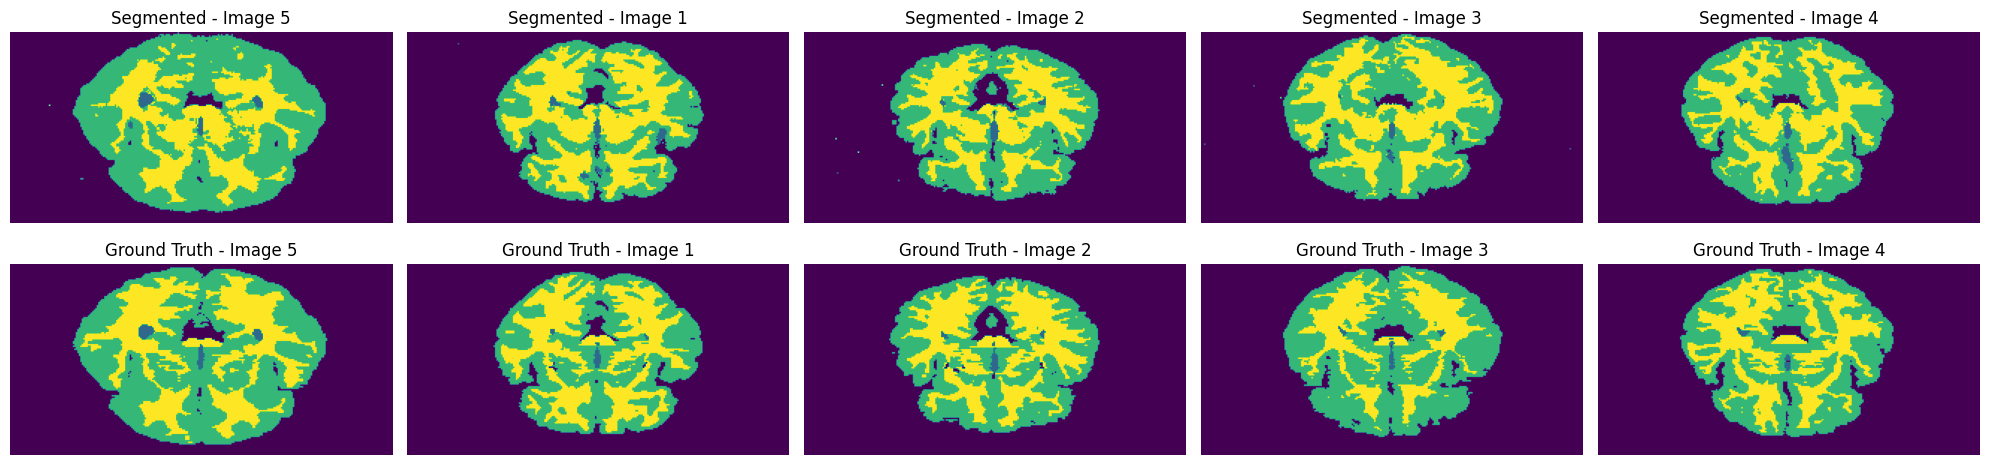

In [18]:
# Select 5 random indices for images to plot
indices = random.sample(range(len(valid_processed_labels)), 5)

# Plot the images
plt.figure(figsize=(20, 5))

for i, index in enumerate(indices, 1):
    
    # Plot segmented images
    plt.subplot(2, 5, i)
    plt.imshow(valid_processed_predictions[index][125,:,:,:].argmax(axis=-1), cmap='viridis')  
    plt.title(f'Segmented - Image {index + 1}')
    plt.axis('off')
    
    # Plot groundtruth 
    plt.subplot(2, 5, i + 5)
    plt.imshow(valid_labels[index][125,:,:,:], cmap='viridis')  
    plt.title(f'Ground Truth - Image {index + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Performance Evaluation
- **Define functions for computing Dice Scores (DSC), Housdroff Distances (HD), Absolute Volume Differences (AVD)**

In [19]:
# Define a function for computing Dice Scores (DSC)
def compute_dice_score(prediction, ground_truth):
    """
    Calculate Dice coefficients for each class between prediction and ground truth.

    Args:
    - prediction    : Predicted values.
    - ground_truth  : Ground truth values.

    Returns:
    - scores        : List containing Dice coefficients for each class.
    """
    
    # Define list to store Dice coefficients for each class
    scores = []  
    
    for i in range(N_CLASSES):
        
        # Seperate class channels
        prediction_each_class = prediction[:, :, :, i]
        ground_truth_each_class = ground_truth[:, :, :, i]

        # Flatten the images to 1D arrays
        prediction_flat = prediction_each_class.flatten()
        ground_truth_flat = ground_truth_each_class.flatten()

        # Calculate intersection, union, and Dice coefficient
        intersection = np.sum(prediction_flat * ground_truth_flat)
        union = np.sum(prediction_flat) + np.sum(ground_truth_flat)
        score = (2.0 * intersection) / (union + 1e-8)  
        scores.append(score)
        
    return scores




# Define a function for Hausdorff Disatances (HD)
def compute_hausdorff_distance(predictions, labels):
    """
    Compute the Hausdorff Distance for each class between predictions and labels.

    Args:
    - predictions   : Predicted masks.
    - labels        : Ground truth masks.

    Returns:
    - distances     : Dictionary containing Hausdorff Distance for each class.
    """
    classes = ['Background', 'CSF', 'GM', 'WM']
    distances = {}

    for i, class_name in enumerate(classes):
        # Extract masks for the specific class
        pred_mask = predictions[:,:,:,i]
        label_mask = labels[:,:,:,i]

        # Find coordinates where the mask is True
        pred_coordinates = np.argwhere(pred_mask)
        label_coordinates = np.argwhere(label_mask)

        # Compute Hausdorff Distance
        if len(pred_coordinates) > 0 and len(label_coordinates) > 0:
            distance = directed_hausdorff(pred_coordinates, label_coordinates)[0]
            distances[class_name] = distance
        else:
            distances[class_name] = np.nan  

    return distances




# Define a function for computing Absolute Volumn Differences (AVD)
def compute_avd(predictions, labels):
    """
    Compute the Absolute Volume Difference (AVD) for each class between predictions and labels.

    Args:
    - predictions   : Predicted masks.
    - labels        : Ground truth masks.

    Returns:
    - avd           : Dictionary containing Absolute Volume Difference for each class.
    """
    classes = ['Background', 'CSF', 'GM', 'WM']
    avd = {}

    for i, class_name in enumerate(classes):
        # Extract masks for the specific class
        pred_mask = predictions[:,:,:,i]
        label_mask = labels[:,:,:,i]

        # Compute volumes
        pred_volume = np.sum(pred_mask)
        label_volume = np.sum(label_mask)

        # Compute Absolute Volume Difference (AVD)
        avd[class_name] = abs(pred_volume - label_volume)

    return avd

- **Compute the Dice Score (DSC)**

In [20]:
# Define list to store Dice coefficients for each image
dice_scores = []  

# Iterate over segemented images to compute dice score
for i in range(len(valid_processed_predictions)): 
    
    # Calculate Dice coefficients for each class between predicted and ground truth images
    dice_coeff = compute_dice_score(valid_processed_predictions[i], valid_processed_labels[i])
    dice_scores.append(dice_coeff)

# Create a Pandas DataFrame to display the Dice coefficients
dice_scores_df = pd.DataFrame(dice_scores)
dice_scores_df.columns = ['Background', 'CSF', 'GM', 'WM']  
print('Dice Scores:')
dice_scores_df

Dice Scores:


,Background,CSF,GM,WM
0,0.997172,0.594076,0.877438,0.893502
1,0.996582,0.714854,0.881547,0.869965
2,0.996274,0.716923,0.868372,0.808149
3,0.997208,0.814634,0.918208,0.902397
4,0.995790,0.791837,0.885270,0.775447


- **Compute the Housdroff Distances (HD)**

In [21]:
# Define list to store Hausdorff Distance for each image
hd_distances = []  

# Iterate over segemented images to compute dice score
for i in range(len(valid_processed_predictions)): 
    
    # Calculate Dice coefficients for each class between predicted and ground truth images
    hd_distance = compute_hausdorff_distance(valid_processed_predictions[i], valid_processed_labels[i])
    hd_distances.append(hd_distance)

# Create a Pandas DataFrame to display the Dice coefficients
hd_distances_df = pd.DataFrame(hd_distances)
hd_distances_df.columns = ['Background', 'CSF', 'GM', 'WM']  
print('Hausdorff Distances:')
hd_distances_df

Hausdorff Distances:


,Background,CSF,GM,WM
0,17.492856,152.239942,115.810190,119.209899
1,17.916473,151.940778,121.383689,127.773237
2,21.587033,146.819617,108.761206,116.636186
3,18.384776,151.049661,107.508139,113.934192
4,25.787594,139.082709,105.138005,111.085553


- **Compute the Absolute Volumn Differences (AVD)**

In [22]:
# Define list to store Hausdorff Distance for each image
volumn_differences = []  

# Iterate over segemented images to compute dice score
for i in range(len(valid_processed_predictions)): 
    
    # Calculate Dice coefficients for each class between predicted and ground truth images
    volumn_difference = compute_avd(valid_processed_predictions[i], valid_processed_labels[i])
    volumn_differences.append(volumn_difference)

# Create a Pandas DataFrame to display the Dice coefficients
volumn_differences_df = pd.DataFrame(volumn_differences)
volumn_differences_df.columns = ['Background', 'CSF', 'GM', 'WM']  
print('Volumn Differences:')
volumn_differences_df


Volumn Differences:


,Background,CSF,GM,WM
0,1231.0,9032.0,39076.0,31275.0
1,9000.0,6396.0,36041.0,20645.0
2,9380.0,1347.0,84107.0,94834.0
3,22713.0,1717.0,1585.0,19411.0
4,19171.0,3732.0,114958.0,92055.0


- **Show statistical analysis for each class.**

In [23]:
# Define the class names
class_names = ['Background', 'CSF', 'GM', 'WM']

# Calculate statistics for Dice Scores
dice_stats = pd.DataFrame(index=class_names)
dice_stats['Mean'] = dice_scores_df.mean()
dice_stats['Standard Deviation'] = dice_scores_df.std()
dice_stats.loc['Overall'] = [dice_scores_df.values.mean(), dice_scores_df.values.std()]

# Calculate statistics for HD distances
hd_stats = pd.DataFrame(index=class_names)
hd_stats['Mean'] = hd_distances_df.mean()
hd_stats['Standard Deviation'] = hd_distances_df.std()
hd_stats.loc['Overall'] = [hd_distances_df.values.mean(), hd_distances_df.values.std()]

# Calculate statistics for absolute volume differences
vol_stats = pd.DataFrame(index=class_names)
vol_stats['Mean'] = volumn_differences_df.mean()
vol_stats['Standard Deviation'] = volumn_differences_df.std()
vol_stats.loc['Overall'] = [volumn_differences_df.values.mean(), volumn_differences_df.values.std()]

# Display DataFrames
print("Dice Scores Statistics:")
print(dice_stats)
print("\n\nHD Distances Statistics:")
print(hd_stats)
print("\n\nAbsolute Volume Differences Statistics:")
print(vol_stats)


Dice Scores Statistics:
                Mean  Standard Deviation
Background  0.996605            0.000604
CSF         0.726465            0.086313
GM          0.886167            0.018985
WM          0.849892            0.055557
Overall     0.864782            0.107128


HD Distances Statistics:
                  Mean  Standard Deviation
Background   20.233746            3.499198
CSF         148.226541            5.555674
GM          111.720246            6.706963
WM          117.727813            6.379850
Overall      99.477087           48.067757


Absolute Volume Differences Statistics:
                    Mean  Standard Deviation
Background  12299.000000         8625.258789
CSF          4444.799805         3255.569336
GM          55153.398438        44464.148438
WM          51644.000000        38448.750000
Overall     30885.300781        34988.226562


# Result Summary

In [24]:
# Define a fucntion to generate table for showing trail details
def generate_trial_details(trail_number, model_name, dice_scores, houssfield_distances, avd):
    trial_details = [
        ["Trial", f"Trail - {trail_number}", "", "", "", ""],
        ["Model", model_name, "", "", "", ""],
        ["Parameters", "Epochs = 30; Batch Size = 60; LR = 0.0001; Optimizer = Adam", "", "", "", ""],
        ["Dataset", "Validation Dataset", "", "", ""],
        ["Class", "", "Background", "CSF", "GM", "WM"],
        ["Dice Score (Mean)"] + [""] + [dice_scores['Background']] + [dice_scores[key] for key in ['CSF', 'GM', 'WM']],
        ["Houssfield Distance (Mean)"] + [""] + [houssfield_distances[key] for key in ['Background', 'CSF', 'GM', 'WM']],
        ["AVD (Mean)"] + [""] + [avd[key] for key in ['Background', 'CSF', 'GM', 'WM']],
    ]
    return trial_details

# Data for trail 1
trials_1 = [
    {
        'model_name': "U-Net",
        'dice_scores': {
            'Background': 0.9965,
            'CSF': 0.714,
            'GM': 0.880,
            'WM': 0.841
        },
        'houssfield_distances': {
            'Background': 19.08,
            'CSF': 48.03,
            'GM': 14.13,
            'WM': 10.94
        },
        'avd': {
            'Background': 14090,
            'CSF': 4630,
            'GM': 58148,
            'WM': 69814
        }
    }
]

# Data for trail 2
trials_2 = [
    {
        'model_name': "ResNet50-UNet",
        'dice_scores': {
            'Background': 0.993,
            'CSF': 0.622,
            'GM': 0.845,
            'WM': 0.764
        },
        'houssfield_distances': {
            'Background': 22.88,
            'CSF': 33.31,
            'GM': 14.11,
            'WM': 11.55
        },
        'avd': {
            'Background': 53724,
            'CSF': 7577,
            'GM': 52972,
            'WM': 46144
        }
    }
]

# Generate and print tables for trials in trials_1 list
for i, trial in enumerate(trials_1, start=1):
    trial_details = generate_trial_details(
        i, trial['model_name'], trial['dice_scores'], trial['houssfield_distances'], trial['avd']
    )
    print(f"Trail {i} Details:")
    print(tabulate(trial_details, headers="firstrow", tablefmt="pretty"))
    print("\n")

# Generate and print tables for trials in trials_2 list
for i, trial in enumerate(trials_2, start=1):
    trial_details = generate_trial_details(
        i+1, trial['model_name'], trial['dice_scores'], trial['houssfield_distances'], trial['avd']
    )
    print(f"Trail {i+1} Details:")
    print(tabulate(trial_details, headers="firstrow", tablefmt="pretty"))
    print("\n")

Trail 1 Details:
+----------------------------+-------------------------------------------------------------+------------+-------+-------+-------+
|           Trial            |                          Trail - 1                          |            |       |       |       |
+----------------------------+-------------------------------------------------------------+------------+-------+-------+-------+
|           Model            |                            U-Net                            |            |       |       |       |
|         Parameters         | Epochs = 30; Batch Size = 60; LR = 0.0001; Optimizer = Adam |            |       |       |       |
|          Dataset           |                     Validation Dataset                      |            |       |       |       |
|           Class            |                                                             | Background |  CSF  |  GM   |  WM   |
|     Dice Score (Mean)      |                                           

# References

- **UNet Model:** https://github.com/anwai98/Brain-Tissue-Seg
- **Segmentation Models:** https://segmentation-models.readthedocs.io/en/latest/index.html

**The End**